In [1]:
# !pip install nixtla

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nixtla import NixtlaClient

Initialize the Nixtla client to access forecasting models:

- `NixtlaClient` connects to the Nixtla API using your personal API key.
- Replace `"YOUR_API_KEY_HERE"` with your actual API key.
- This client allows you to make forecasts, retrieve model results, and interact with Nixtla services programmatically.


In [ ]:
nixtla_client = NixtlaClient(api_key = "YOUR_API_KEY_HERE")

In [4]:

# Download NVIDIA stock data
data = yf.download('NVDA', start='2020-01-01', end='2025-10-01', interval='1d')

/var/folders/94/18sqr3292qj66m2k622fh4580000gn/T/ipykernel_74806/2902550880.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('NVDA', start='2020-01-01', end='2025-10-01', interval='1d')
[*********************100%***********************]  1 of 1 completed


In [5]:
df = pd.DataFrame(data=data.values, columns=['Close', 'High', 'Low', 'Open', 'Volume'])
df.insert(0, 'Date', data.index)
df

,Date,Close,High,Low,Open,Volume
0,2020-01-02,5.971409,5.971409,5.892010,5.942537,237536000.0
1,2020-01-03,5.875832,5.919639,5.826798,5.851688,205384000.0
2,2020-01-06,5.900473,5.905700,5.756359,5.782493,262636000.0
3,2020-01-07,5.971907,6.017705,5.883795,5.928847,314856000.0
4,2020-01-08,5.983109,6.024426,5.927603,5.967677,277108000.0
...,...,...,...,...,...,...
1439,2025-09-24,176.970001,179.779999,175.399994,179.770004,143564100.0
1440,2025-09-25,177.690002,180.259995,173.130005,174.479996,191586700.0
1441,2025-09-26,178.190002,179.770004,174.929993,178.169998,148573700.0
1442,2025-09-29,181.850006,184.000000,180.320007,180.429993,193063500.0


Ensure the DataFrame has a complete daily date range, including weekends and holidays:

- Convert the 'Date' column to datetime objects for accurate handling.
- Create a full daily date range from the earliest to the latest date in the dataset.
- Set 'Date' as the index to align the DataFrame with the full date range.
- `reindex` adds missing dates, including weekends and holidays.
- `ffill()` (forward fill) propagates the last available value to fill any missing entries.
- Reset the index and rename it back to 'Date' to restore the original column structure.


In [6]:
df['Date'] = pd.to_datetime(df['Date'])
full_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
df = df.set_index('Date')
df = df.reindex(full_dates)
df = df.ffill()
df = df.reset_index().rename(columns={'index': 'Date'})

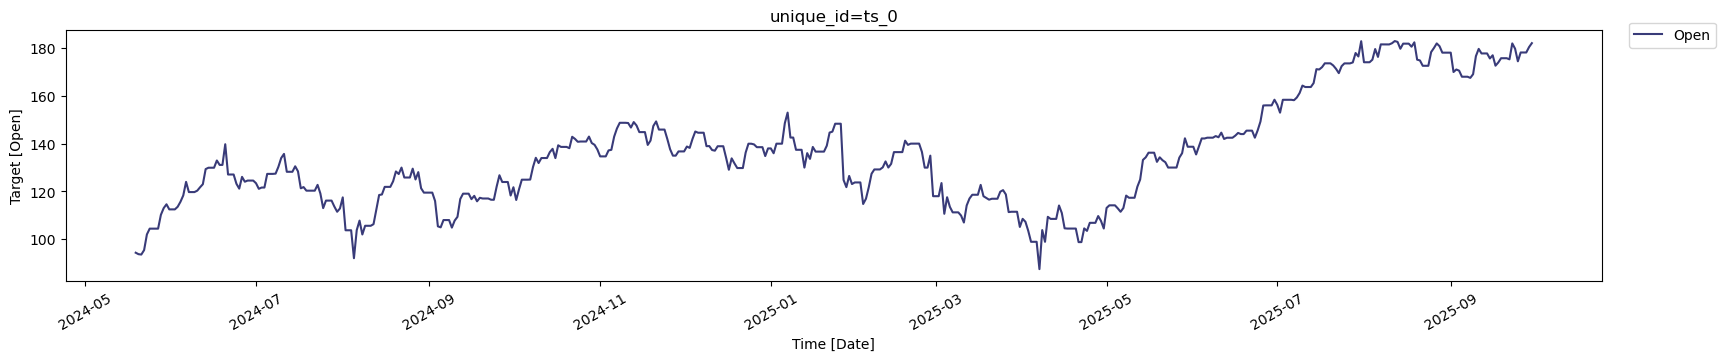

In [7]:
nixtla_client.plot(df.iloc[-500:,:], time_col="Date", target_col="Open")

Use the Nixtla client to forecast future stock prices with TimeGPT:

- `n_past = 14` defines how many days ahead we want to forecast.
- `df.iloc[:-n_past, :]` uses all data except the last `n_past` days for training.
- `h=n_past` sets the forecast horizon (number of days to predict).
- `freq='D'` specifies daily frequency.
- `time_col="Date"` tells the model which column contains dates.
- `target_col="Open"` specifies the column we want to predict.
- `model='timegpt-1-long-horizon'` chooses the TimeGPT long-horizon forecasting model.
- `timegpt_fcst_df.head()` displays the first few rows of the forecast results.


In [8]:
n_past = 14
timegpt_fcst_df = nixtla_client.forecast(df=df.iloc[:-n_past, :], h=n_past, freq='D', time_col="Date", target_col="Open", model='timegpt-1-long-horizon')
timegpt_fcst_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
/opt/anaconda3/lib/python3.11/site-packages/nixtla/nixtla_client.py:380: UserWarning: `df` contains the following exogenous features: ['Close', 'High', 'Low', 'Volume'], but `X_df` was not provided and they were not declared in `hist_exog_list`. They will be ignored.
  warnings.warn(
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


,Date,TimeGPT
0,2025-09-17,180.54095
1,2025-09-18,181.94205
2,2025-09-19,181.98370
3,2025-09-20,181.25860
4,2025-09-21,179.54877


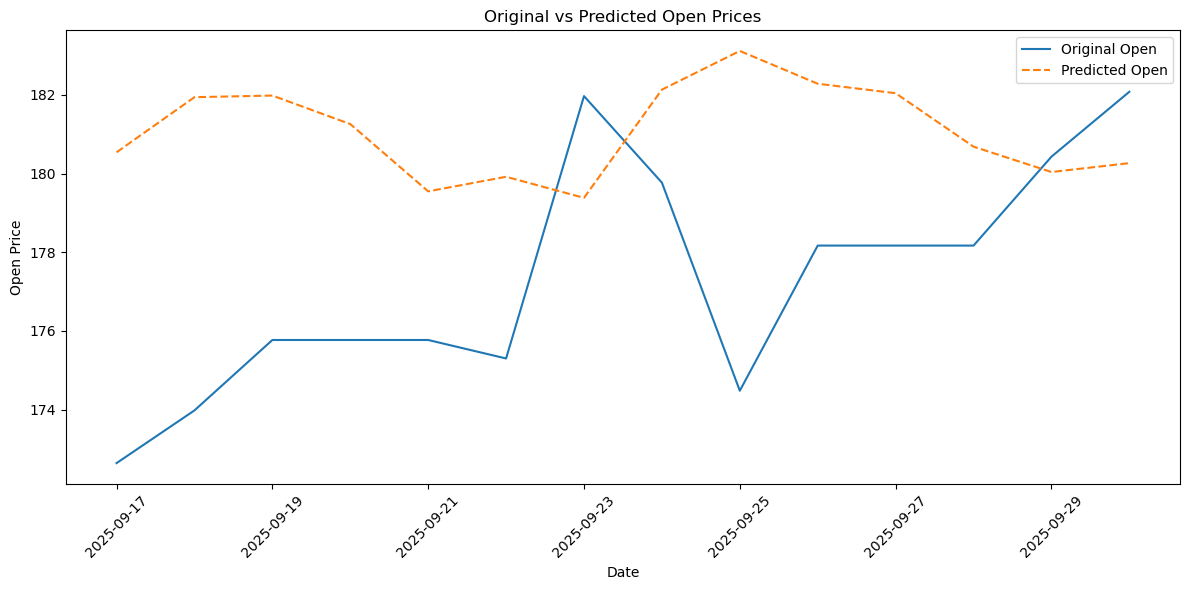

In [9]:

plt.figure(figsize=(12, 6))

# Original Open prices (last 14 days)
sns.lineplot(data=df.iloc[-n_past:, :], x='Date', y='Open', label='Original Open')
sns.lineplot(data=timegpt_fcst_df, x='Date', y='TimeGPT', label='Predicted Open', linestyle='--')
plt.title('Original vs Predicted Open Prices')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
